In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# pre-prosesing

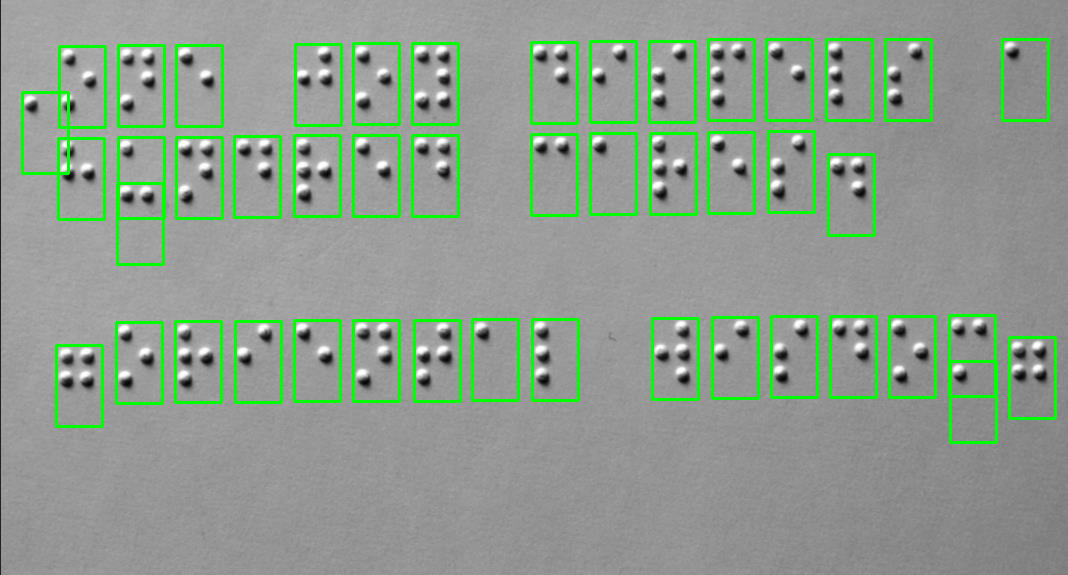

In [3]:
def process_and_crop_image(image_path, output_dir, output_final_image='braille_letters_fixed_with_boxes.jpg', target_size=(32, 32)):
    """
    Proses gambar untuk mendeteksi kontur, membuat bounding box,
    dan memotong tiap huruf dari gambar braille, serta memastikan
    ukuran hasil crop sesuai dengan kebutuhan model.

    Args:
    - image_path (str): Path ke file gambar input.
    - output_dir (str): Directory untuk menyimpan hasil crop.
    - output_final_image (str): Nama file untuk gambar dengan bounding box.
    - target_size (tuple): Ukuran gambar yang diinginkan untuk input model.

    Returns:
    - List of cropped images yang telah diresize.
    """
    # Buat direktori output jika belum ada
    os.makedirs(output_dir, exist_ok=True)
    # Baca gambar
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Membuat citra biner
    _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)

    # Menggabungkan titik-titik dalam satu huruf
    kernel = np.ones((20, 10), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)

    # Deteksi kontur
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ambil bounding box dan ukuran terbesar
    bounding_boxes = []
    max_width = 0
    max_height = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if 10 < w < 100 and 10 < h < 100:  # Filter ukuran
            bounding_boxes.append((x, y, x + w, y + h))
            max_width = max(max_width, w)
            max_height = max(max_height, h)

    # Urutkan bounding box
    bounding_boxes.sort(key=lambda box: (box[1], box[0]))

    # Kelompokkan bounding box dalam baris berdasarkan posisi y
    bars = []
    current_bar = []
    last_y = bounding_boxes[0][1]
    bar_threshold = 20

    for box in bounding_boxes:
        x1, y1, x2, y2 = box
        if abs(y1 - last_y) < bar_threshold:
            current_bar.append(box)
        else:
            bars.append(sorted(current_bar, key=lambda b: b[0]))
            current_bar = [box]
        last_y = y1
    bars.append(sorted(current_bar, key=lambda b: b[0]))

    # Gambar bounding box dan crop setiap huruf
    final_image = image.copy()
    cropped_images = []

    # Simpan gambar crop sesuai urutan baris dan kolom dengan format penamaan
    for bar_idx, bar in enumerate(bars, 1):
        for col_idx, box in enumerate(bar, 1):
            x1, y1, x2, y2 = box

            # Tetapkan ukuran bounding box menjadi ukuran terbesar tanpa mengubah titik awal
            new_x2 = x1 + max_width
            new_y2 = y1 + max_height

            # Crop gambar menggunakan bounding box yang telah disesuaikan
            cropped_image = image[y1:new_y2, x1:new_x2]

            # Resize gambar crop sesuai dengan target_size
            resized_image = cv2.resize(cropped_image, target_size)

            cropped_images.append(resized_image)

            # Format penamaan file
            filename = f'{output_dir}/braille_letter_bar_{bar_idx:03d}_col_{col_idx:03d}.jpg'
            cv2.imwrite(filename, resized_image)

            # Gambar bounding box pada gambar akhir dengan ukuran baru
            cv2.rectangle(final_image, (x1, y1), (new_x2, new_y2), (0, 255, 0), 2)

    # Simpan gambar dengan bounding box
    cv2.imwrite(output_final_image, final_image)

    # Tampilkan hasil akhir dengan bounding box
    cv2_imshow(final_image)

    # Menampilkan gambar crop sesuai urutan
    for cropped_image in cropped_images:
        cv2_imshow(cropped_image)

    return cropped_images

# Contoh pemanggilan fungsi
cropped_images = process_and_crop_image(
    image_path='/content/drive/MyDrive/images/val/0000093.jpg',
    output_dir='/content/sample_data/cropped_images',
    target_size=(28, 28)
)


# model predict


In [6]:
# Memuat model yang telah dilatih
model_path = '/content/drive/MyDrive/braille1.h5'
model = load_model(model_path)

# Fungsi untuk memuat dan memproses gambar
def load_and_process_image(image_path, target_size=(28, 28)):
    img = image.load_img(image_path, target_size=target_size)  # Ganti ukuran sesuai input model
    img_array = img_to_array(img) / 255.0  # Normalisasi gambar ke rentang [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    return img_array

# Fungsi untuk melakukan prediksi
def predict_image(model, image_path, label_dict):
    img_array = load_and_process_image(image_path)  # Proses gambar
    prediction = model.predict(img_array)  # Prediksi
    predicted_class = np.argmax(prediction)  # Ambil kelas dengan probabilitas tertinggi
    reverse_label_dict = {v: k for k, v in label_dict.items()}  # Reverse dictionary untuk label
    predicted_label = reverse_label_dict[predicted_class]  # Dapatkan label prediksi
    return predicted_label

# Label dictionary (sesuaikan dengan label yang digunakan selama pelatihan)
label_dict = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8,
              'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16,
              'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
              'z': 25, 'empty': 26}

# Path folder gambar
image_folder = '/content/sample_data/cropped_images'

# Proses dan prediksi semua gambar dalam folder
predictions = {}
for image_file in sorted(os.listdir(image_folder)):  # Urutkan file berdasarkan nama
    if image_file.endswith(('.jpg', '.png')):  # Filter file gambar
        image_path = os.path.join(image_folder, image_file)
        predicted_label = predict_image(model, image_path, label_dict)
        predictions[image_file] = predicted_label
        print(f"Predicted label for {image_file}: {predicted_label}")

        # Tampilkan gambar yang diprediksi
        img = image.load_img(image_path)
        cv2_imshow(np.array(img))

# Simpan hasil prediksi ke file teks
output_path = '/content/sample_data/predictions.txt'
with open(output_path, 'w') as f:
    for image_file, predicted_label in predictions.items():
        f.write(f"{image_file}: {predicted_label}\n")

print(f"Predictions saved to {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Predicted label for braille_letter_bar_001_col_001.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted label for braille_letter_bar_001_col_002.jpg: n


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted label for braille_letter_bar_001_col_003.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_004.jpg: j


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_005.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label for braille_letter_bar_001_col_006.jpg: z


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_007.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_008.jpg: i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_009.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_010.jpg: b


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_011.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_012.jpg: b


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label for braille_letter_bar_001_col_013.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_014.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_002_col_001.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label for braille_letter_bar_003_col_001.jpg: j


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for braille_letter_bar_003_col_002.jpg: u


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label for braille_letter_bar_003_col_003.jpg: n


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_003_col_004.jpg: d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label for braille_letter_bar_003_col_005.jpg: r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_003_col_006.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_003_col_007.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_003_col_008.jpg: c


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_003_col_009.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_003_col_010.jpg: r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_003_col_011.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label for braille_letter_bar_003_col_012.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for braille_letter_bar_003_col_013.jpg: d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted label for braille_letter_bar_004_col_001.jpg: c


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_001.jpg: j


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label for braille_letter_bar_005_col_002.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_003.jpg: r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_004.jpg: i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_005_col_005.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_006.jpg: n


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for braille_letter_bar_005_col_007.jpg: t


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_008.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_009.jpg: l


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for braille_letter_bar_005_col_010.jpg: w


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for braille_letter_bar_005_col_011.jpg: i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label for braille_letter_bar_005_col_012.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_013.jpg: d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label for braille_letter_bar_005_col_014.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_015.jpg: m


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_016.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_005_col_017.jpg: j


Predictions saved to /content/sample_data/predictions.txt


# **Menyusun Huruf Berdasarkan Baris dan Kolom**

In [10]:
def organize_predictions(predictions):
    """
    Mengatur prediksi berdasarkan baris dan kolom dari nama file.

    Args:
        predictions (dict): Dictionary prediksi dengan format nama file sebagai kunci.

    Returns:
        list: List teks yang tersusun berdasarkan baris.
    """
    # Dictionary untuk menyimpan huruf berdasarkan baris
    organized = {}

    for image_file, predicted_label in predictions.items():
        try:
            # Ekstrak nomor baris dan kolom dari nama file
            parts = image_file.split('_')
            row = int(parts[3].replace("bar", ""))  # Baris dari "bar_001"
            col = int(parts[5].replace("col", "").split('.')[0])  # Kolom dari "col_001.jpg"

            # Tambahkan ke dictionary berdasarkan baris
            if row not in organized:
                organized[row] = []
            organized[row].append((col, predicted_label))
        except (IndexError, ValueError):
            print(f"Skipping file with invalid format: {image_file}")

    # Susun huruf berdasarkan baris dan kolom
    sorted_text = []
    for row in sorted(organized.keys()):
        # Urutkan berdasarkan kolom dan gabungkan huruf dalam satu baris
        organized[row].sort(key=lambda x: x[0])  # Urutkan berdasarkan nomor kolom
        sorted_text.append("".join([label for _, label in organized[row]]))

    return sorted_text


In [11]:
sorted_text = organize_predictions(predictions)

# Tampilkan hasil tersusun
print("Sorted Text by Rows:")
for row in sorted_text:
    print(row)


Sorted Text by Rows:
onejozeisbebsa
a
jundreecaresd
c
jorientalwisdomaj


# main pipeline

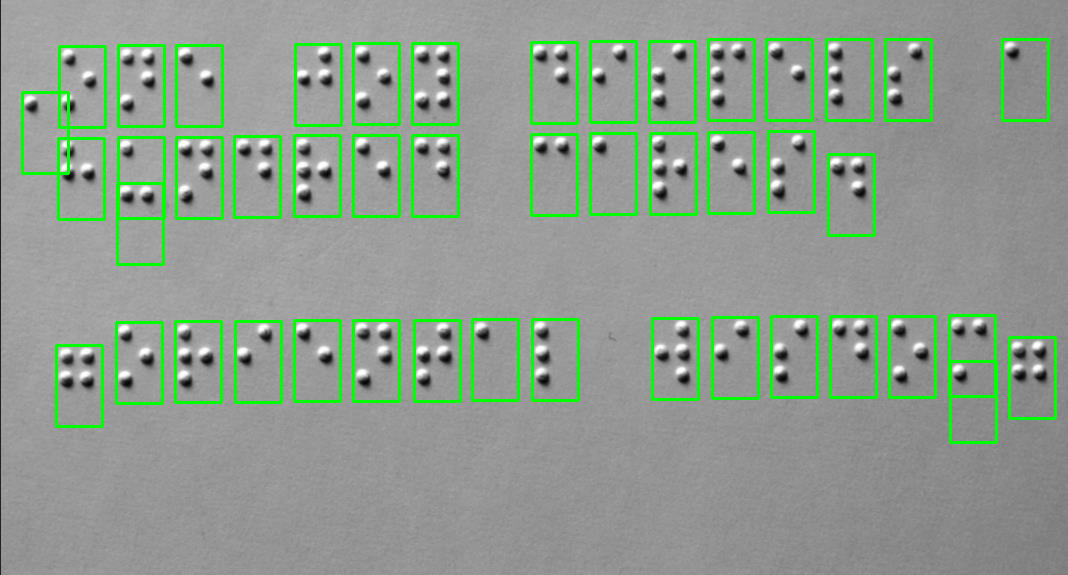

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Predicted label for braille_letter_bar_001_col_001.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for braille_letter_bar_001_col_002.jpg: n


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for braille_letter_bar_001_col_003.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for braille_letter_bar_001_col_004.jpg: j


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted label for braille_letter_bar_001_col_005.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_006.jpg: z


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted label for braille_letter_bar_001_col_007.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_008.jpg: i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_009.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_010.jpg: b


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label for braille_letter_bar_001_col_011.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_001_col_012.jpg: b


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_001_col_013.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for braille_letter_bar_001_col_014.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label for braille_letter_bar_002_col_001.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_003_col_001.jpg: j


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label for braille_letter_bar_003_col_002.jpg: u


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label for braille_letter_bar_003_col_003.jpg: n


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label for braille_letter_bar_003_col_004.jpg: d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label for braille_letter_bar_003_col_005.jpg: r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label for braille_letter_bar_003_col_006.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label for braille_letter_bar_003_col_007.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label for braille_letter_bar_003_col_008.jpg: c


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted label for braille_letter_bar_003_col_009.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted label for braille_letter_bar_003_col_010.jpg: r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for braille_letter_bar_003_col_011.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted label for braille_letter_bar_003_col_012.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted label for braille_letter_bar_003_col_013.jpg: d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted label for braille_letter_bar_004_col_001.jpg: c


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted label for braille_letter_bar_005_col_001.jpg: j


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted label for braille_letter_bar_005_col_002.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted label for braille_letter_bar_005_col_003.jpg: r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted label for braille_letter_bar_005_col_004.jpg: i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted label for braille_letter_bar_005_col_005.jpg: e


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted label for braille_letter_bar_005_col_006.jpg: n


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted label for braille_letter_bar_005_col_007.jpg: t


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted label for braille_letter_bar_005_col_008.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted label for braille_letter_bar_005_col_009.jpg: l


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted label for braille_letter_bar_005_col_010.jpg: w


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted label for braille_letter_bar_005_col_011.jpg: i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label for braille_letter_bar_005_col_012.jpg: s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label for braille_letter_bar_005_col_013.jpg: d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted label for braille_letter_bar_005_col_014.jpg: o


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted label for braille_letter_bar_005_col_015.jpg: m


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted label for braille_letter_bar_005_col_016.jpg: a


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted label for braille_letter_bar_005_col_017.jpg: j


Predictions saved to /content/sample_data/cropped_images/predictions.txt
onejozeisbebsa
a
jundreecaresd
c
jorientalwisdomaj


In [14]:
def main_pipeline(image_path, output_dir, model_path, target_size=(28, 28), output_final_image='braille_letters_fixed_with_boxes.jpg'):
    """
    Pipeline utama untuk memproses gambar, memprediksi huruf Braille, dan mengorganisir hasil prediksi.

    Args:
    - image_path (str): Path ke file gambar input.
    - output_dir (str): Direktori untuk menyimpan hasil crop dan gambar bounding box.
    - model_path (str): Path ke model yang sudah dilatih.
    - target_size (tuple): Ukuran gambar yang diinginkan untuk input model.
    - output_final_image (str): Nama file untuk gambar dengan bounding box.

    Returns:
    - List of teks hasil prediksi.
    """
    # Step 1: Proses dan crop gambar Braille
    cropped_images = process_and_crop_image(
        image_path=image_path,
        output_dir=output_dir,
        target_size=target_size,
        output_final_image=output_final_image
    )

    # Step 2: Muat model yang telah dilatih
    model = load_model(model_path)

    # Step 3: Fungsi untuk memuat dan memproses gambar
    def load_and_process_image(image_path, target_size=(28, 28)):
        img = image.load_img(image_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalisasi gambar ke rentang [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
        return img_array

    # Step 4: Fungsi untuk melakukan prediksi
    def predict_image(model, image_path, label_dict):
        img_array = load_and_process_image(image_path)  # Proses gambar
        prediction = model.predict(img_array)  # Prediksi
        predicted_class = np.argmax(prediction)  # Ambil kelas dengan probabilitas tertinggi
        reverse_label_dict = {v: k for k, v in label_dict.items()}  # Reverse dictionary untuk label
        predicted_label = reverse_label_dict[predicted_class]  # Dapatkan label prediksi
        return predicted_label

    # Label dictionary (sesuaikan dengan label yang digunakan selama pelatihan)
    label_dict = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8,
                  'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16,
                  'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
                  'z': 25, 'empty': 26}

    # Step 5: Proses dan prediksi semua gambar dalam folder hasil crop
    predictions = {}
    for image_file in sorted(os.listdir(output_dir)):  # Urutkan file berdasarkan nama
        if image_file.endswith(('.jpg', '.png')):  # Filter file gambar
            image_path = os.path.join(output_dir, image_file)
            predicted_label = predict_image(model, image_path, label_dict)
            predictions[image_file] = predicted_label
            print(f"Predicted label for {image_file}: {predicted_label}")

            # Tampilkan gambar yang diprediksi
            img = image.load_img(image_path)
            cv2_imshow(np.array(img))

    # Step 6: Menyimpan hasil prediksi ke file teks
    output_path = os.path.join(output_dir, 'predictions.txt')
    with open(output_path, 'w') as f:
        for image_file, predicted_label in predictions.items():
            f.write(f"{image_file}: {predicted_label}\n")

    print(f"Predictions saved to {output_path}")

    # Step 7: Mengorganisir hasil prediksi berdasarkan baris dan kolom
    organized_text = organize_predictions(predictions)

    # Menampilkan teks akhir
    for line in organized_text:
        print(line)

    return organized_text



image_path = '/content/drive/MyDrive/images/val/0000093.jpg'
output_dir = '/content/sample_data/cropped_images'
model_path = '/content/drive/MyDrive/braille1.h5'

organized_text = main_pipeline(
    image_path=image_path,
    output_dir=output_dir,
    model_path=model_path,
    target_size=(28, 28)
)



# class mapping

In [ ]:
label_dict = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8,
              'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16,
              'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
              'z': 25, 'empty': 26}

# model doc

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

**labeling and split the dataset**

In [ ]:
# Fungsi untuk memuat gambar dan label
def load_and_label_image(image_path, label):
    img = image.load_img(image_path, target_size=(28, 28))
    img_array = image.img_to_array(img) / 255.0  # Normalisasi gambar
    return img_array, label

# Fungsi untuk memuat semua gambar dan label dari struktur direktori
def load_images_and_labels(image_dir):
    images = []
    labels = []
    label_dict = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9,
                  'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19,
                  'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'empty': 26}  # 'a' to 'z' + 'empty'

    for subdir in os.listdir(image_dir):
        subdir_path = os.path.join(image_dir, subdir)
        if os.path.isdir(subdir_path):  # Hanya untuk sub-direktori
            if subdir == 'empty':  # Untuk 'empty' label tetap 26
                label = label_dict['empty']
            elif subdir in label_dict:
                label = label_dict[subdir]  # Gunakan label yang sesuai dengan huruf
            else:
                continue
            for filename in os.listdir(subdir_path):
                if filename.endswith('.jpg' or '.png'):
                    image_path = os.path.join(subdir_path, filename)
                    img_array, label = load_and_label_image(image_path, label)
                    images.append(img_array)
                    labels.append(label)

    return np.array(images), np.array(labels), label_dict

# Tentukan direktori dataset Anda
image_dir = '/content/drive/MyDrive/Braille_Dataset'

# Memuat gambar dan label
X, y, label_dict = load_images_and_labels(image_dir)

# Membagi data menjadi train, validation, dan test secara stratified
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Konversi label ke one-hot encoding dengan menambahkan 1 untuk accommodate 'empty'
num_classes = len(label_dict)  # Menghitung total jumlah kelas
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Cek ukuran subset
print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)
print("Label mapping:", label_dict)


Train size: (1248, 28, 28, 3)
Validation size: (156, 28, 28, 3)
Test size: (156, 28, 28, 3)
Label mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'empty': 26}


# **Build Model**

In [ ]:
model = keras.Sequential([
    # convo 1
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu', input_shape=(28, 28, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    # convo 2
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    #convo 3
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    # flatten layer
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    # dense layer
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=27, activation="softmax")
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**compile model**

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Mengonfigurasi EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor metrik yang ingin dipantau
    patience=10,                    # Jumlah epoch tanpa perbaikan sebelum menghentikan pelatihan
    verbose=1,                     # Menampilkan informasi saat pelatihan dihentikan lebih awal
    restore_best_weights=True      # Mengembalikan bobot model ke yang terbaik berdasarkan metrik yang dipantau
)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)


In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.5, 1.2],
)

datagen.fit(X_train)

In [ ]:
model.fit(X_train, y_train,batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9890 - loss: 0.0409 - val_accuracy: 0.9551 - val_loss: 0.1576
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9871 - loss: 0.0524 - val_accuracy: 0.9551 - val_loss: 0.1483
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9830 - loss: 0.0578 - val_accuracy: 0.9872 - val_loss: 0.1199
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9867 - loss: 0.0429 - val_accuracy: 0.9808 - val_loss: 0.1163
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9779 - loss: 0.0505 - val_accuracy: 0.9231 - val_loss: 0.3316
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9845 - loss: 0.0544 - val_accuracy: 0.9423 - val_loss: 0.1984
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9783 - loss: 0.0699 - val_accuracy: 0.9808 - val_loss: 0.0981
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9698 - loss: 0.0767 - val_accuracy: 0.9744 - val_loss:

In [ ]:
# Evaluasi model pada data pengujian
test_loss, test_accuracy = model.evaluate(X_test, y_test)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9218 - loss: 0.3635 
Test Loss: 0.3182973265647888
Test Accuracy: 0.9230769276618958


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# Evaluasi menggunakan metrik
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - Precision: 0.9283 - Recall: 0.9218 - accuracy: 0.9218 - loss: 0.3635
Test Loss: 0.3182973265647888
Test Accuracy: 0.9230769276618958
Test Precision: 0.9350649118423462
Test Recall: 0.9230769276618958


In [ ]:
# Membuat prediksi pada data pengujian
predictions = model.predict(X_test)

# Menghitung akurasi prediksi
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Menghitung akurasi
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy on test data: {accuracy}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Accuracy on test data: 0.9230769230769231


In [ ]:
model.save('/content/drive/MyDrive/braille1.h5')

In [ ]:
model.save('/content/drive/MyDrive/saved_model/my_model')